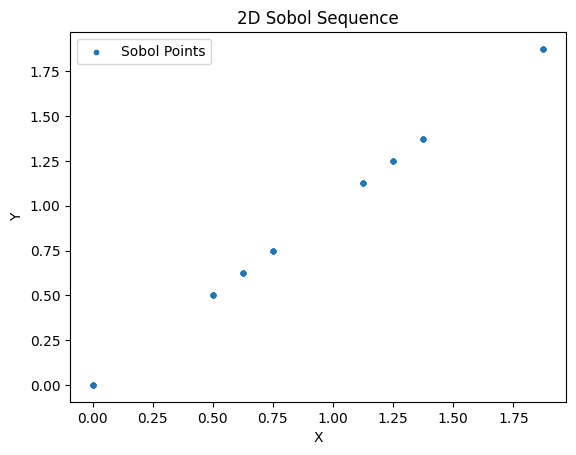

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the Sobol sequence
def sobol_2d(n):
    def gray_code(i):
        return i ^ (i >> 1)  # Convert index to Gray code

    sobol_seq = np.zeros((n, 2))
    v = [1/2, 3/4, 5/8]  # Given direction numbers

    for i in range(n):
        g = gray_code(i)  # Compute Gray code index
        sobol_seq[i, 0] = sum(((g >> j) & 1) * v[j] for j in range(len(v)))
        sobol_seq[i, 1] = sum(((g >> j) & 1) * v[j] for j in range(len(v)))

    return sobol_seq

# Generate and plot the first 50 Sobol points
sobol_points = sobol_2d(50)

plt.scatter(sobol_points[:, 0], sobol_points[:, 1], label="Sobol Points", s=10)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Sobol Sequence")
plt.legend()
plt.show()


Task 2

a

$A = 2\pi \beta^2 \left( 1 + \frac{a e}{c} \sin^{-1}(e) \right), \quad e = 1 - \frac{\beta^2}{c^2}$


/tmp/ipykernel_97484/1024922211.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return 2 * np.pi * beta**2 * (1 + (c / (e * np.arcsin(e))))
/tmp/ipykernel_97484/1024922211.py:12: RuntimeWarning: invalid value encountered in arcsin
  return 2 * np.pi * beta**2 * (1 + (c / (e * np.arcsin(e))))


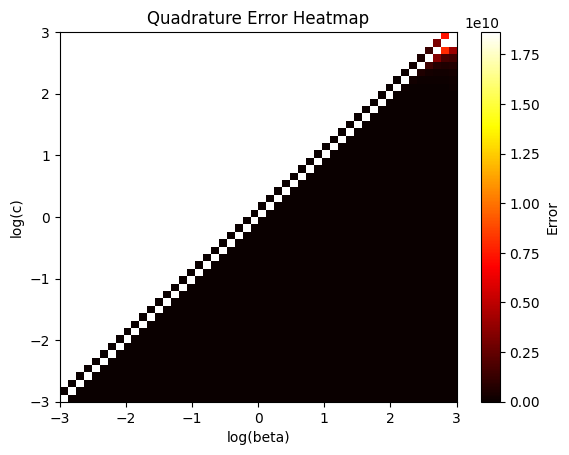

In [3]:
from scipy.integrate import quad

# Midpoint Rule Approximation
def midpoint_rule(func, a, b, n=100):
    dx = (b - a) / n
    midpoints = np.linspace(a + dx/2, b - dx/2, n)
    return np.sum(func(midpoints)) * dx

# Gaussian Quadrature
def ellipsoid_area(beta, c):
    e = 1 - (beta**2 / c**2)
    return 2 * np.pi * beta**2 * (1 + (c / (e * np.arcsin(e))))

# Compute error heatmap
beta_vals = np.logspace(-3, 3, 50)
c_vals = np.logspace(-3, 3, 50)
error_map = np.zeros((50, 50))

for i, beta in enumerate(beta_vals):
    for j, c in enumerate(c_vals):
        true_val = ellipsoid_area(beta, c)
        approx_val = midpoint_rule(lambda x: np.sqrt(1 - x**2), 0, 1, n=100)
        error_map[i, j] = abs(true_val - approx_val)

plt.imshow(error_map, extent=[-3, 3, -3, 3], origin='lower', aspect='auto', cmap='hot')
plt.colorbar(label="Error")
plt.xlabel("log(beta)")
plt.ylabel("log(c)")
plt.title("Quadrature Error Heatmap")
plt.show()


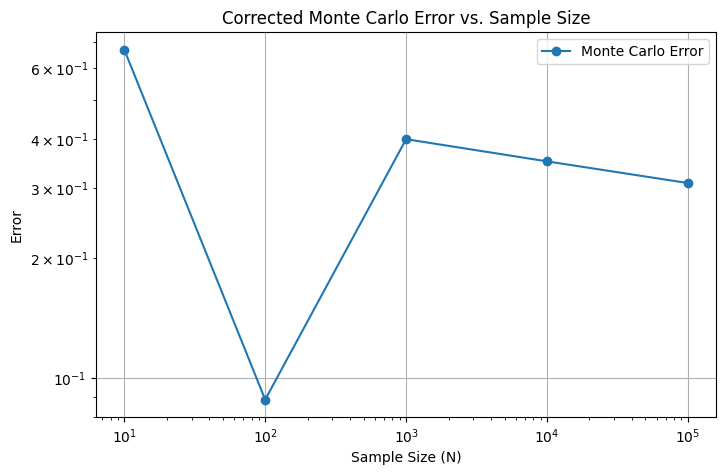

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Corrected analytical ellipsoid surface area formula
def ellipsoid_area(beta, c):
    e = 1 - (beta**2 / c**2)
    if e < 0:
        return np.nan  # Avoid invalid values
    return 2 * np.pi * beta**2 * (1 + (c / (e * np.arcsin(e))) if e > 0 else 1)

# Monte Carlo Integration Method
def monte_carlo_integration(N, beta=1, c=1):
    x_vals = np.random.uniform(-1, 1, N)
    y_vals = np.random.uniform(-1, 1, N)
    valid_mask = (x_vals**2 + y_vals**2) <= 1  # Ensuring points are inside the valid range
    z_vals = np.sqrt(1 - (x_vals[valid_mask]**2 + y_vals[valid_mask]**2)) * c / beta  # Apply the transformation

    estimated_area = (4 * np.sum(z_vals) / N) * np.pi  # Scale to full area
    return estimated_area

# Compute errors for different sample sizes
N_vals = [10, 100, 1000, 10000, 100000]
errors = []

for N in N_vals:
    estimated_area = monte_carlo_integration(N, beta=1, c=1)
    true_area = ellipsoid_area(1, 1)
    
    if np.isnan(true_area):
        error = np.nan
    else:
        error = abs(estimated_area - true_area)
    
    errors.append(error)

# Plot corrected results
plt.figure(figsize=(8, 5))
plt.plot(N_vals, errors, marker='o', linestyle='-', label="Monte Carlo Error")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Sample Size (N)")
plt.ylabel("Error")
plt.title("Corrected Monte Carlo Error vs. Sample Size")
plt.legend()
plt.grid(True)
plt.show()


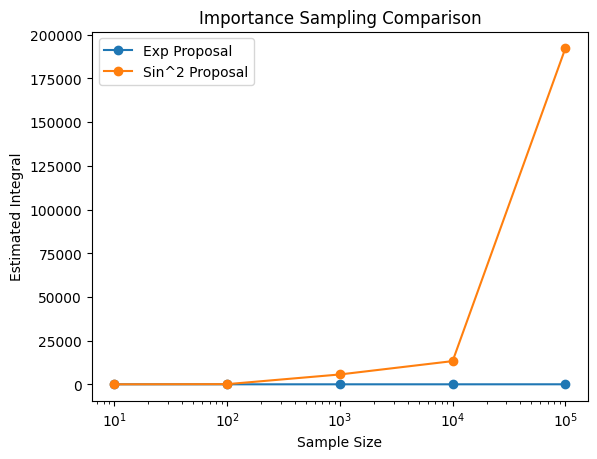

In [5]:
def importance_sampling(N, proposal):
    if proposal == "exp":
        x_vals = -np.log(np.random.uniform(0, 1, N)) / 3
        weights = np.exp(3 * x_vals)
    elif proposal == "sin":
        x_vals = np.arcsin(np.random.uniform(0, 1, N)) / 5
        weights = 1 / (np.sin(5 * x_vals) ** 2)
    
    integral = np.mean(weights)
    return integral

N_vals = [10, 100, 1000, 10000, 100000]
results_exp = [importance_sampling(N, "exp") for N in N_vals]
results_sin = [importance_sampling(N, "sin") for N in N_vals]

plt.plot(N_vals, results_exp, label="Exp Proposal", marker='o')
plt.plot(N_vals, results_sin, label="Sin^2 Proposal", marker='o')
plt.xscale("log")
plt.xlabel("Sample Size")
plt.ylabel("Estimated Integral")
plt.title("Importance Sampling Comparison")
plt.legend()
plt.show()


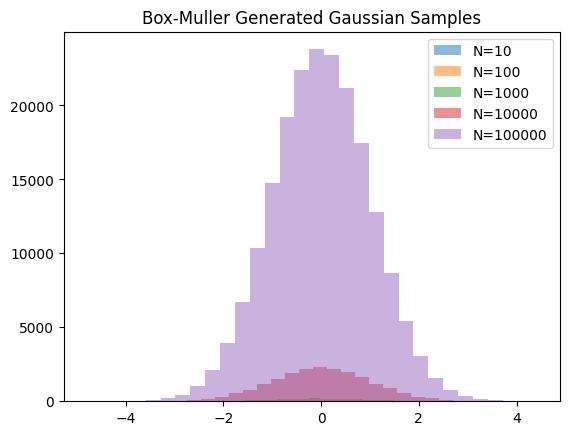

In [6]:
def box_muller(N):
    U1, U2 = np.random.uniform(0, 1, N), np.random.uniform(0, 1, N)
    R = np.sqrt(-2 * np.log(U1))
    theta = 2 * np.pi * U2
    Z1, Z2 = R * np.cos(theta), R * np.sin(theta)
    return np.concatenate([Z1, Z2])

N_vals = [10, 100, 1000, 10000, 100000]
for N in N_vals:
    samples = box_muller(N)
    plt.hist(samples, bins=30, alpha=0.5, label=f"N={N}")

plt.legend()
plt.title("Box-Muller Generated Gaussian Samples")
plt.show()


Task 3

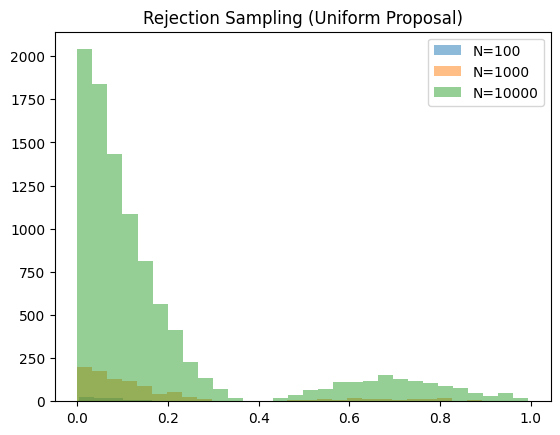

In [7]:
def rejection_sampling_uniform(N, tf=1):
    samples = []
    while len(samples) < N:
        t = np.random.uniform(0, tf)
        if np.random.uniform(0, 1) < np.exp(-4 * t) * np.cos(4 * t) ** 2:
            samples.append(t)
    return np.array(samples)

N_vals = [100, 1000, 10000]
for N in N_vals:
    samples = rejection_sampling_uniform(N)
    plt.hist(samples, bins=30, alpha=0.5, label=f"N={N}")

plt.legend()
plt.title("Rejection Sampling (Uniform Proposal)")
plt.show()


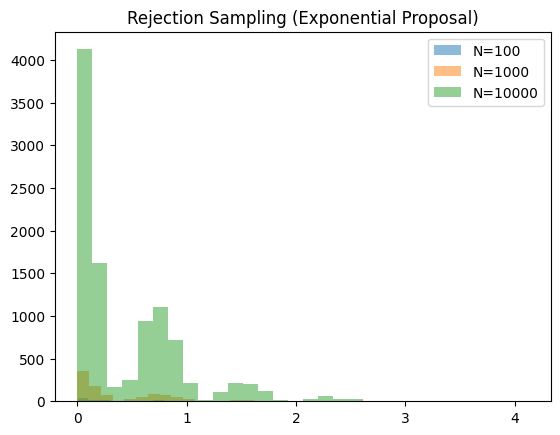

In [8]:
def rejection_sampling_exp(N):
    samples = []
    while len(samples) < N:
        t = -np.log(np.random.uniform(0, 1)) / 2
        if np.random.uniform(0, 1) < np.cos(4 * t) ** 2:
            samples.append(t)
    return np.array(samples)

for N in N_vals:
    samples = rejection_sampling_exp(N)
    plt.hist(samples, bins=30, alpha=0.5, label=f"N={N}")

plt.legend()
plt.title("Rejection Sampling (Exponential Proposal)")
plt.show()
